# Machine learning analysis

In this notebook are shown all the steps towards an optimal and accurate prediccion of activities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
sns.set()

Let's first load the dataframe generated after analyzing all the images:

In [2]:
df=pd.read_csv('ntcir12.csv',sep='\t', index_col='Unnamed: 0')

This are the tags given by the YOLO processing:

In [3]:
tags=['person','chair', 'book', 'tvmonitor', 'laptop', 'bottle','cup', 'car','diningtable', 'cell phone',
             'keyboard', 'bowl', 'mouse', 'clock','toilet', 'sink', 'remote', 'suitcase', 'pottedplant','refrigerator',
             'knife', 'handbag', 'vase', 'aeroplane', 'cat','bed', 'sofa', 'backpack', 'tie', 'spoon', 'toothbrush',
             'traffic light', 'bicycle', 'train', 'bird', 'microwave', 'bench','fork', 'oven', 'motorbike', 'donut',
             'wine glass', 'pizza','apple', 'scissors', 'umbrella', 'cake', 'bus', 'truck','banana', 'parking meter',
             'sandwich', 'sports ball', 'broccoli','carrot', 'orange', 'teddy bear', 'dog', 'snowboard','skateboard', 'boat',
             'surfboard', 'frisbee', 'skis', 'hot dog','bear', 'elephant', 'toaster', 'stop sign', 'hair drier', 'kite',
             'sheep', 'zebra', 'tennis racket', 'baseball bat', 'fire hydrant','horse', 'cow', 'giraffe', 'baseball glove']

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.head(5)

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,G_bin7,G_bin8,B_bin1,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.034097,0.052746,0.022873,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.000065,0.000076,0.067223,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.005265,0.014378,0.155595,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.003570,0.003003,0.136579,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.008912,0.000051,0.044834,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487


In [6]:
# import modules 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [7]:
#import different Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#import other features
from sklearn.metrics import accuracy_score

Our first try is with the tags generated by YOLO for each image and with a simple classifier, a k-nearest neighbors algorithm (k-NN):

In [8]:
# will use KNN as the initial classifier
acc_neigh=[]
X1=df[tags]
y1=df['activity']
for neighbor in xrange(1,12): #iterate using different neighbours from 1 to 10
    acc= []
    for i in xrange(10): #iterate 10 times for every neighbour
        x_train1, x_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.3) 
        knn= KNeighborsClassifier(n_neighbors=neighbor)
        knn.fit(x_train1,y_train1)
        acc.append(knn.score(x_test1,y_test1)) # accuracy score
    acc_neigh.append(np.mean(acc)) # append mean value for every neighbour
    print 'neighbor {} processed'.format(neighbor)
   

neighbor 1 processed
neighbor 2 processed
neighbor 3 processed
neighbor 4 processed
neighbor 5 processed
neighbor 6 processed
neighbor 7 processed
neighbor 8 processed
neighbor 9 processed
neighbor 10 processed
neighbor 11 processed


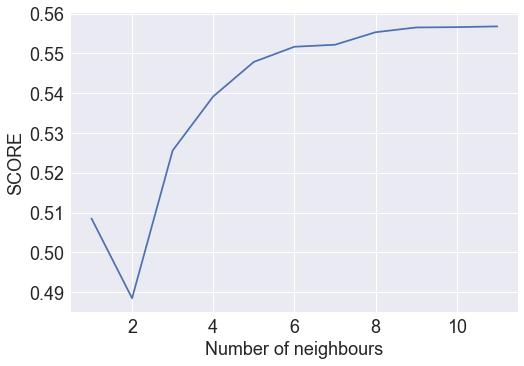

In [9]:
# plot the results
scores = acc_neigh
plt.plot(np.arange(1,12),scores)
plt.xlabel('Number of neighbours',fontsize= 18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylabel('SCORE',fontsize= 18)
plt.show()         

In [10]:
PRC = 0.3
acc_r=np.zeros((10,5))
X=df[tags]
y=df['activity']
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    nn2 = KNeighborsClassifier(n_neighbors=2)
    nn5 = KNeighborsClassifier(n_neighbors=5)
    svc = SVC()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier(n_estimators=100)
    
    nn2.fit(X_train,y_train)
    nn5.fit(X_train,y_train)
    svc.fit(X_train,y_train)
    dt.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    
    y_pred_nn2=nn2.predict(X_test)
    y_pred_nn5=nn5.predict(X_test)
    y_pred_svc=svc.predict(X_test)
    y_pred_dt=dt.predict(X_test)
    y_pred_rf=rf.predict(X_test)
    
    acc_r[i][0] = accuracy_score(y_pred_nn2, y_test)
    acc_r[i][1] = accuracy_score(y_pred_nn5, y_test)
    acc_r[i][2] = accuracy_score(y_pred_svc, y_test)
    acc_r[i][3] = accuracy_score(y_pred_dt, y_test)
    acc_r[i][4] = accuracy_score(y_pred_rf, y_test)

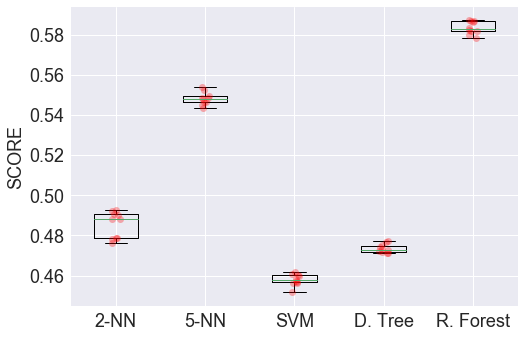

In [11]:
plt.boxplot(acc_r);
for i in xrange(5):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['2-NN','5-NN','SVM','D. Tree', 'R. Forest'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylabel('SCORE',fontsize= 18)
plt.show()

In [12]:
PRC = 0.3
X=df[tags]
y=df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)   
y_pred_rf=rf.predict(X_test)
print accuracy_score(y_test,y_pred_rf)

0.592266890006


As seen in the graph above, Random Forest with 100 estimators gives the best accuracy.

In [13]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.49      0.46      0.47       290
                     biking       0.67      0.44      0.53        78
        cleaning and chores       0.51      0.42      0.46       225
                    cooking       0.52      0.45      0.48       172
                    driving       0.54      0.61      0.57       888
having drinks with somebody       0.44      0.46      0.45       416
   having drinks\meal alone       0.63      0.44      0.52       479
  having meal with somebody       0.66      0.67      0.66       297
                    meeting       0.46      0.36      0.40       521
                     mobile       0.60      0.66      0.63      1436
                      plane       0.67      0.54      0.60       316
                    reading       0.57      0.45      0.50       343
                    resting       0.66      0.82      0.74      1399
                   shopping      

In [14]:
y_train[y_train == 'biking'].count()

173

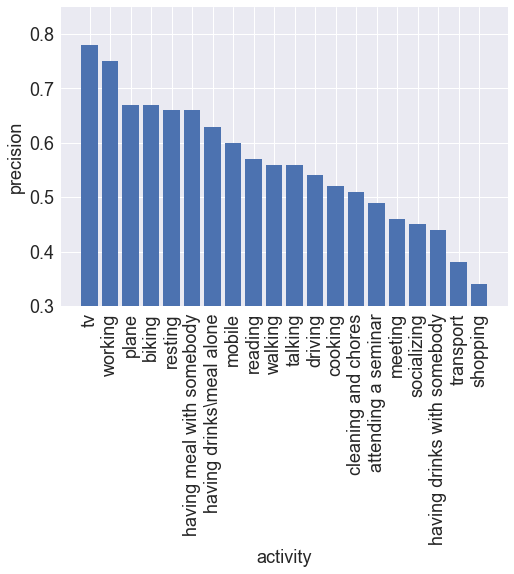

In [15]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:                
                value= float(v[33:39])
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.3,0.85])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

[('walking', 5384), ('working', 4498), ('resting', 3410), ('mobile', 3258), ('transport', 2715), ('driving', 1978), ('talking', 1822), ('meeting', 1255), ('socializing', 1247), ('having drinks\\meal alone', 1108), ('having drinks with somebody', 1002), ('tv', 843), ('reading', 824), ('shopping', 786), ('having meal with somebody', 736), ('attending a seminar', 733), ('plane', 714), ('cleaning and chores', 568), ('cooking', 375), ('biking', 173)]


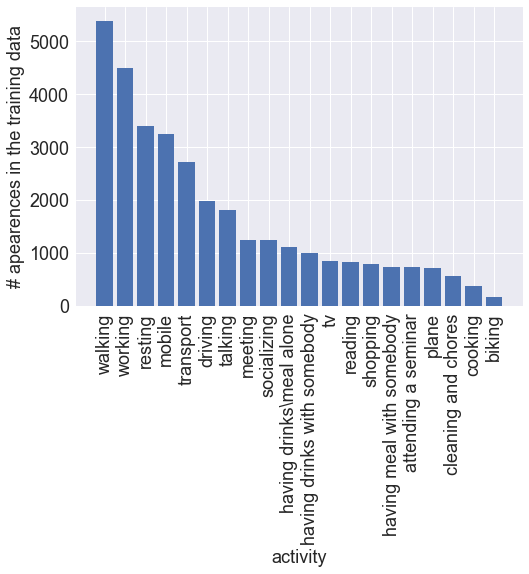

In [16]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
    
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)
print list1
x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


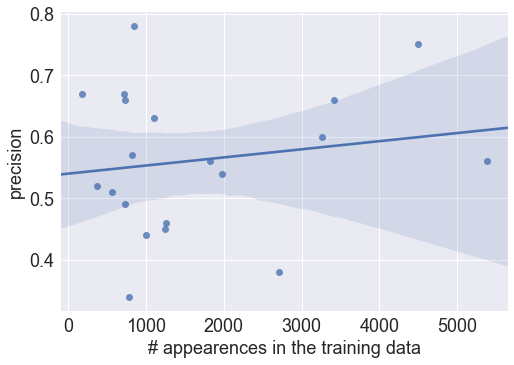

In [17]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()     

In [78]:
def plot_confusion_matrix(test, pred,normalize=False):
    cm=confusion_matrix(test,pred)
    
    if normalize: 
        cm = cm.astype('float')/cm.sum(axis= 1)
        plt.imshow(cm,cmap=plt.cm.jet, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('Predicted label',fontsize= 18)
        plt.ylabel('True label',fontsize= 18)
        x_act= np.sort(y.unique())   
        plt.xticks(np.arange(0,len(x_act)),x_act,rotation=90,fontsize= 18)
        plt.yticks(np.arange(0,len(x_act)),x_act,rotation=0,fontsize= 18)
        plt.grid('off')
        plt.show()

    else:
        plt.imshow(cm,cmap=plt.cm.jet, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('Predicted label',fontsize= 18)
        plt.ylabel('True label',fontsize= 18)
        x_act= np.sort(y.unique())   
        plt.xticks(np.arange(0,len(x_act)),x_act,rotation=90,fontsize= 18)
        plt.yticks(np.arange(0,len(x_act)),x_act,rotation=0,fontsize= 18)
        plt.grid('off')
        plt.show()

    
    

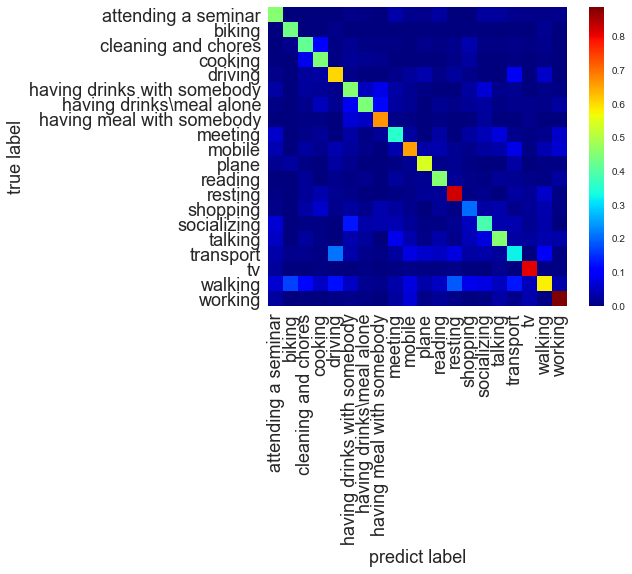

In [19]:
a=plot_confusion_matrix(y_test,y_pred_rf,normalize=True)

In [20]:
print "classification accuracy:", accuracy_score(y_test, y_pred_rf)
print "classification accuracy:", rf.score(X_test, y_test)

classification accuracy: 0.592266890006
classification accuracy: 0.592266890006


Our next try is to add two more binary columns: one containing information about location (is he/she at Home or not?) and another about time (Is today Weekend or not?). Our belive is that these two informations will result in a better accuracy. 

In [21]:
mask =  df['location'] == 'Home'
mask = mask.astype(int)

In [22]:
df1=df.copy()

In [23]:
df1['Home'] = mask

In [24]:
mask = df['day_of_week'] > 4
mask = mask.astype(int)

In [25]:
df1['Weekend'] = mask

In [26]:
tags1=['person','chair', 'book', 'tvmonitor', 'laptop', 'bottle','cup', 'car','diningtable', 'cell phone',
             'keyboard', 'bowl', 'mouse', 'clock','toilet', 'sink', 'remote', 'suitcase', 'pottedplant','refrigerator',
             'knife', 'handbag', 'vase', 'aeroplane', 'cat','bed', 'sofa', 'backpack', 'tie', 'spoon', 'toothbrush',
             'traffic light', 'bicycle', 'train', 'bird', 'microwave', 'bench','fork', 'oven', 'motorbike', 'donut',
             'wine glass', 'pizza','apple', 'scissors', 'umbrella', 'cake', 'bus', 'truck','banana', 'parking meter',
             'sandwich', 'sports ball', 'broccoli','carrot', 'orange', 'teddy bear', 'dog', 'snowboard','skateboard', 'boat',
             'surfboard', 'frisbee', 'skis', 'hot dog','bear', 'elephant', 'toaster', 'stop sign', 'hair drier', 'kite',
             'sheep', 'zebra', 'tennis racket', 'baseball bat', 'fire hydrant','horse', 'cow', 'giraffe', 'baseball glove','Home','Weekend']


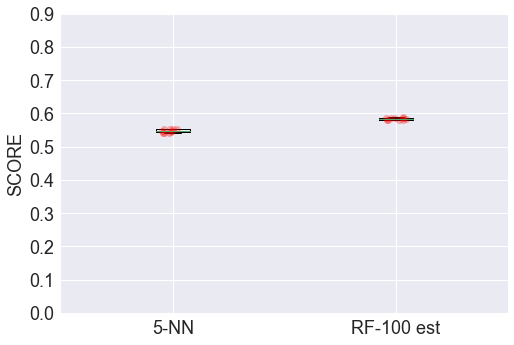

In [27]:
y = df1['activity']
X = df1[tags]

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)
    
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


In [28]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.46      0.39      0.42       300
                     biking       0.46      0.29      0.36        65
        cleaning and chores       0.46      0.34      0.39       249
                    cooking       0.49      0.44      0.46       158
                    driving       0.58      0.60      0.59       888
having drinks with somebody       0.46      0.45      0.46       440
   having drinks\meal alone       0.58      0.45      0.51       437
  having meal with somebody       0.72      0.65      0.68       321
                    meeting       0.46      0.38      0.41       502
                     mobile       0.58      0.64      0.61      1394
                      plane       0.66      0.49      0.56       317
                    reading       0.51      0.49      0.50       342
                    resting       0.67      0.81      0.73      1434
                   shopping      

In [29]:
y_train[y_train == 'biking'].count()

186

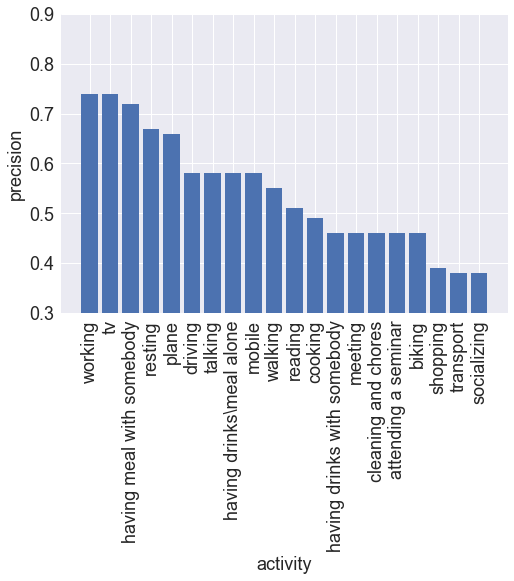

In [30]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:                
                value= float(v[33:39])
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.3,0.9])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

[('walking', 5396), ('working', 4497), ('resting', 3375), ('mobile', 3300), ('transport', 2709), ('driving', 1978), ('talking', 1784), ('socializing', 1277), ('meeting', 1274), ('having drinks\\meal alone', 1150), ('having drinks with somebody', 978), ('tv', 840), ('reading', 825), ('shopping', 779), ('attending a seminar', 723), ('plane', 713), ('having meal with somebody', 712), ('cleaning and chores', 544), ('cooking', 389), ('biking', 186)]


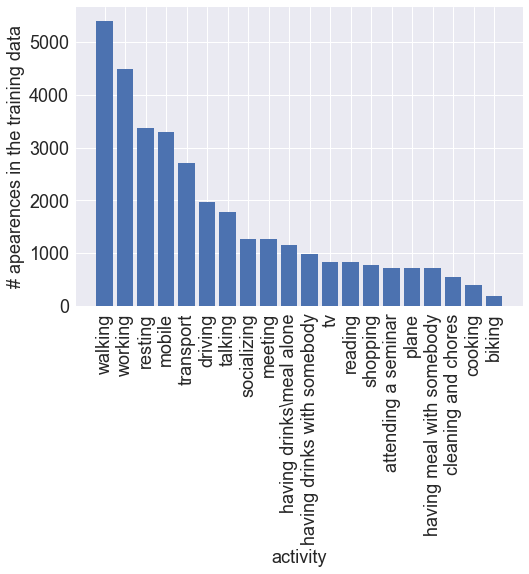

In [31]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
    
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)
print list1
x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


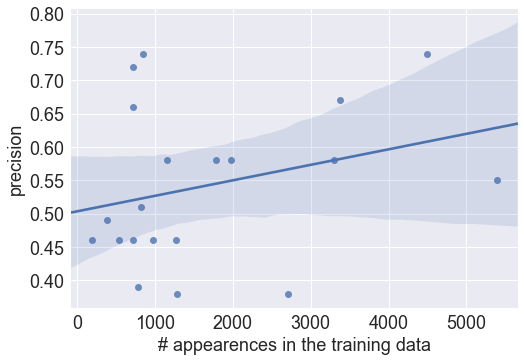

In [32]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()     

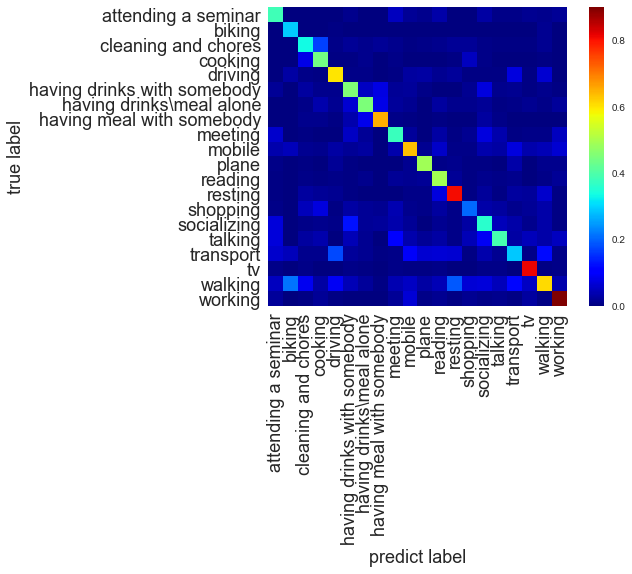

In [33]:
plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

Our next try is to scan each image and extract 8-bins for each RGB channel and add this information to the confusion matrix. In our case, the dataframe imported at the beginig is already filled with such information (See the folder "1.Clean data and add extra features"). Let's see how well it performs now:

This are the new tags that we will add to the previous used tags:

In [34]:
tags_rgb = ['R_bin1', 'R_bin2', 'R_bin3', 'R_bin4', 'R_bin5', 'R_bin6', 'R_bin7', 'R_bin8','G_bin1', 'G_bin2', 'G_bin3', 'G_bin4', 'G_bin5', 'G_bin6', 'G_bin7', 'G_bin8','B_bin1', 'B_bin2', 'B_bin3', 'B_bin4', 'B_bin5', 'B_bin6', 'B_bin7', 'B_bin8']

In [35]:
tags2 = tags1 + tags_rgb

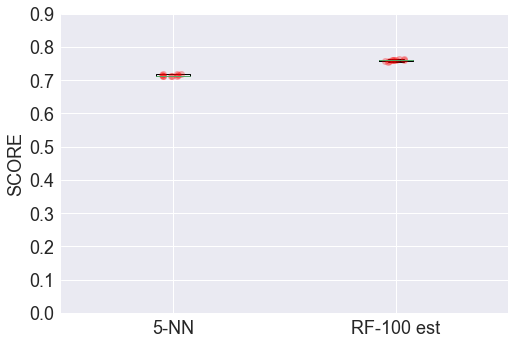

In [36]:
#FULL DETAIL DATA: probability 
y = df1['activity']
X = df1[tags2]

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)
    
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


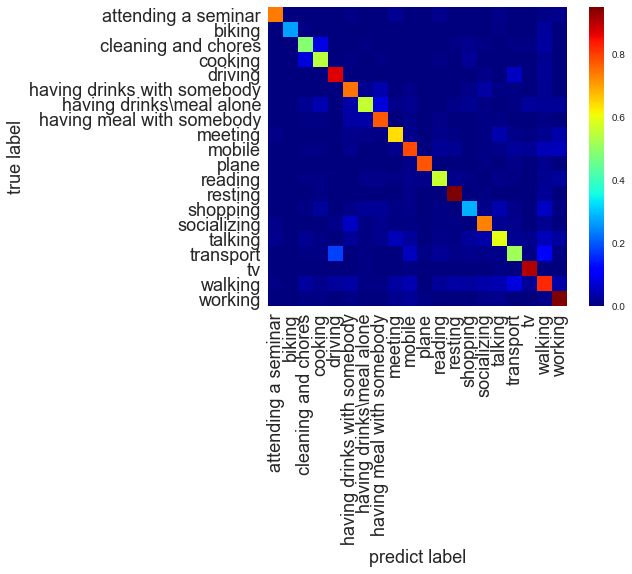

In [37]:
plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

Our final try is to add the last activity performed to the features matrix. 

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
#asigning a value to each of the activities from 0 to 1 (normalized)
dic_act={}
val=np.linspace(0,1,20)
for i,v in enumerate(y.unique()):
    dic_act[v]=val[i]


Each activity has a reference number normalized from 0 to 1:

In [40]:
dic_act

{'attending a seminar': 0.57894736842105265,
 'biking': 1.0,
 'cleaning and chores': 0.78947368421052633,
 'cooking': 0.052631578947368418,
 'driving': 0.31578947368421051,
 'having drinks with somebody': 0.84210526315789469,
 'having drinks\\meal alone': 0.10526315789473684,
 'having meal with somebody': 0.68421052631578938,
 'meeting': 0.89473684210526305,
 'mobile': 0.0,
 'plane': 0.94736842105263153,
 'reading': 0.42105263157894735,
 'resting': 0.21052631578947367,
 'shopping': 0.63157894736842102,
 'socializing': 0.36842105263157893,
 'talking': 0.47368421052631576,
 'transport': 0.73684210526315785,
 'tv': 0.15789473684210525,
 'walking': 0.26315789473684209,
 'working': 0.52631578947368418}

In [41]:
df1.head()

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin1,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.022873,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411,1,0
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.067223,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061,1,0
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.155595,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784,1,0
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.136579,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339,1,0
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.044834,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487,1,0


In [42]:
def get_previous_act(): # function to get the previous activity
    data=df1.activity.values
    val= []
    X = df1[tags2]
    
    for item in range(len(data)): #For each element in the dataframe:
        if item == 0: # We predict the activity for the first element
            result1 = rf.predict(X.ix[item,:])
            valor_previ = np.nan
            val.append(np.nan)
            
        else:
            result2 = rf.predict(X.ix[item,:])
            if result2!=result1: #check if previous activity is different
                val.append(dic_act[result1[0]])
                valor_previ = dic_act[result1[0]]
                result1 = result2
            else:
                val.append(valor_previ)  #If it's not different, we save the previous value
                
    return val

dummy= get_previous_act()


In [43]:
df2=df1.copy()
df2['prev_activity'] = pd.Series(dummy, index=df.index)

In [44]:
tags=['prev_activity']


In [45]:
tags3= tags2+tags

In [46]:
df2 = df2.dropna(how='any',subset=["activity"],axis=0)


In [47]:
df2.head()

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend,prev_activity
2015-02-23 07:08:12,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,mobile,u1_2015-02-23_070812_6,/u1/2015-02-23/b00000006_21i6bq_20150223_07081...,Home,male,...,0.256494,0.174103,0.303694,0.250870,0.168284,0.019045,0.061411,1,0,NaN
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_7,/u1/2015-02-23/b00000007_21i6bq_20150223_07081...,Home,male,...,0.143474,0.209524,0.444543,0.343550,0.001700,0.000072,0.000061,1,0,0.000000
2015-02-23 07:08:13,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070813_8,/u1/2015-02-23/b00000008_21i6bq_20150223_07081...,Home,male,...,0.260709,0.214408,0.441503,0.075073,0.009980,0.005148,0.011784,1,0,0.052632
2015-02-23 07:08:14,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070814_9,/u1/2015-02-23/b00000009_21i6bq_20150223_07081...,Home,male,...,0.447956,0.280991,0.263809,0.031977,0.004851,0.002074,0.001339,1,0,0.263158
2015-02-23 07:08:22,u1,40,1,23/02/2015,NTCIR-Lifelog_images/u1/2015-02-23/,cooking,u1_2015-02-23_070822_10,/u1/2015-02-23/b00000010_21i6bq_20150223_07082...,Home,male,...,0.181883,0.267774,0.521107,0.135849,0.002264,0.002486,0.053487,1,0,0.263158


We have now a new column with information about the previous activity performed at certain time. Let's see if there is an improvement:

In [48]:
#FULL DETAIL DATA: probability 
y = df2[1:]['activity'] #remove the 1st data point
X = df2[1:][tags3] #remove the 1st data point

PRC = 0.3
acc_r=np.zeros((10,2))
for i in xrange(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PRC)
    knn = KNeighborsClassifier(n_neighbors=5)
    rf = RandomForestClassifier(n_estimators=100)
    knn.fit(X_train,y_train)
    rf.fit(X_train,y_train)   
    y_pred_knn= knn.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    acc_r[i][0] = accuracy_score(y_test,y_pred_knn)
    acc_r[i][1] = accuracy_score(y_test,y_pred_rf)

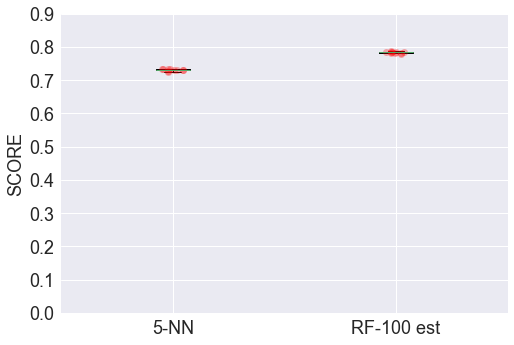

In [49]:
plt.boxplot(acc_r)
for i in xrange(2):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['5-NN','RF-100 est'],fontsize= 18)
plt.yticks(fontsize= 18)
plt.ylim([0, 0.9])
plt.ylabel('SCORE',fontsize= 18)
plt.show()


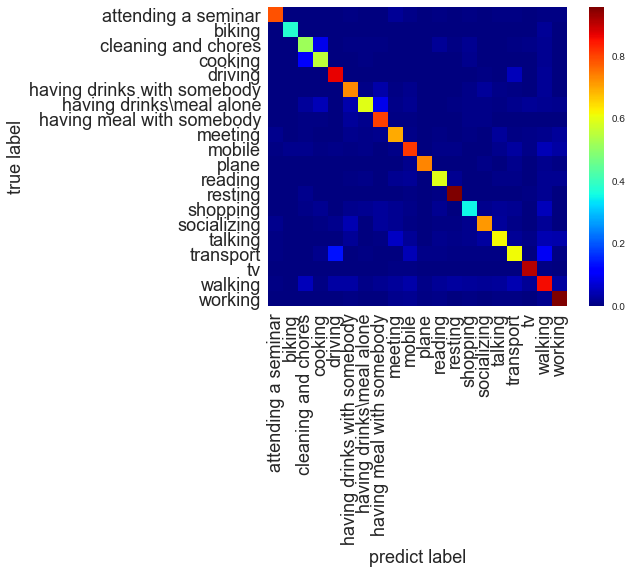

In [50]:
a=plot_confusion_matrix(y_test, y_pred_rf,normalize=True)

In [51]:
print classification_report(y_test,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.93      0.79      0.85       310
                     biking       0.97      0.38      0.54        74
        cleaning and chores       0.70      0.52      0.59       219
                    cooking       0.75      0.56      0.64       176
                    driving       0.81      0.87      0.84       862
having drinks with somebody       0.77      0.73      0.75       422
   having drinks\meal alone       0.86      0.60      0.71       495
  having meal with somebody       0.78      0.81      0.79       284
                    meeting       0.77      0.70      0.73       513
                     mobile       0.77      0.81      0.79      1384
                      plane       0.95      0.74      0.83       292
                    reading       0.82      0.59      0.69       373
                    resting       0.91      0.96      0.93      1473
                   shopping      

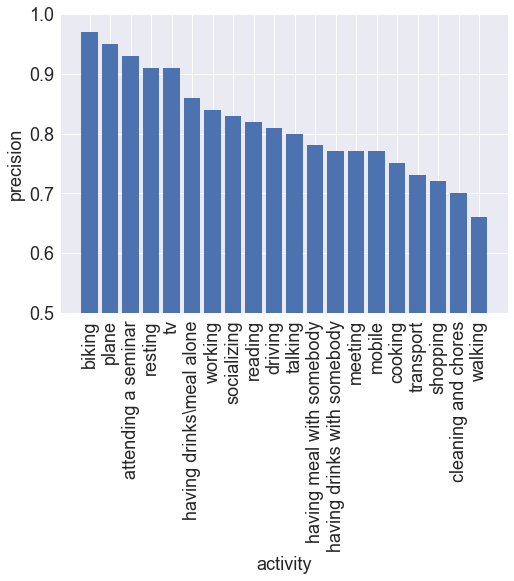

In [52]:
a = classification_report(y_test,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:   
                
                value= float(v[33:39])
                
                precision.append(value)                

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.5,1.0])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

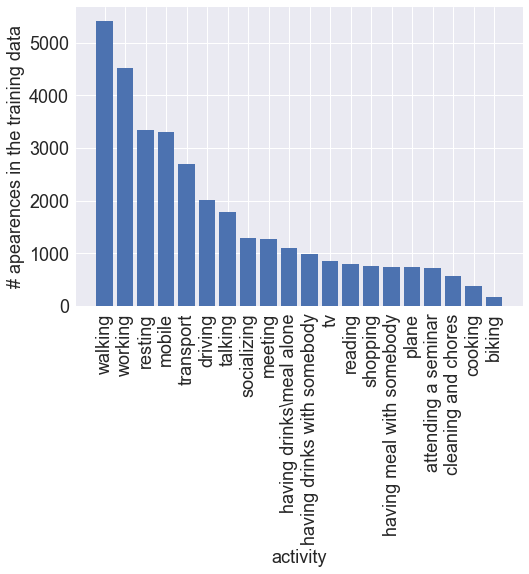

In [53]:
activity_occurences={}
for val in x_val:
    activity_occurences[val]=y_train[y_train==val].count()
   
list1= sorted(activity_occurences.items(), key=lambda x:x[1],reverse=True)

x_val = [x[0] for x in list1]
y_val = [x[1] for x in list1]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val,log=False)
plt.xlabel('activity',fontsize = 18)
plt.ylabel('# apearences in the training data',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()    


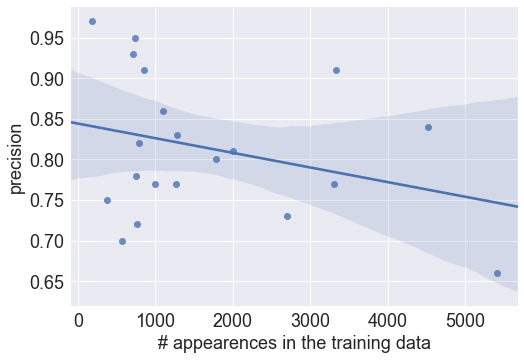

In [54]:
values = np.zeros((len(list),2))
for i in range(len(list)):
    tag = list[i][0]
    valor = list[i][1]
    values[i,1]=activity_occurences[tag]
    values[i,0] = valor
    
sns.regplot(values[:,1], values[:,0],order=1)
plt.xlabel('# appearences in the training data',fontsize = 18)
plt.ylabel('precision',fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
#plt.ylim([0.4,1])
plt.show()     

Let's train our system with data from user 1 and 2, and try to predict the activity of user 3:

In [91]:
#train and test from diffent users
#TRAIN data is made up using user 1 and 2 information 
df_train = df2[df2['user'] !='u2']
df_train = df_train[df_train['user'] !='u3']
y_train = df_train[1:]['activity']
X_train = df_train[1:][tags3]
# TEST data is made up using user 3 information only
df_test =df2[df2['user']=='u2']
test_data= df_test[tags3]
y_data =df_test['activity']
#####

In [93]:
#print unique activity labels for train and test data
print np.sort(y.unique()) 
print np.sort(y_data.unique())

['attending a seminar' 'biking' 'cleaning and chores' 'cooking' 'driving'
 'having drinks with somebody' 'having drinks\\meal alone'
 'having meal with somebody' 'meeting' 'mobile' 'plane' 'reading' 'resting'
 'shopping' 'socializing' 'talking' 'transport' 'tv' 'walking' 'working']
['attending a seminar' 'biking' 'cleaning and chores' 'cooking' 'driving'
 'having drinks with somebody' 'having drinks\\meal alone'
 'having meal with somebody' 'meeting' 'mobile' 'plane' 'reading' 'resting'
 'shopping' 'socializing' 'talking' 'transport' 'tv' 'walking' 'working']


In [92]:
df_train.tail(2)

,user,age,day_id,date,image_directory,activity,image_id,image_path,location,gender,...,B_bin2,B_bin3,B_bin4,B_bin5,B_bin6,B_bin7,B_bin8,Home,Weekend,prev_activity
2015-03-20 05:41:58,u1,40,26,20/03/2015,NTCIR-Lifelog_images/u1/2015-03-20/,walking,u1_2015-03-20_054158_3,/u1/2015-03-20/b00003515_21i6bq_20150320_05415...,Modern Universe Business Plaza,male,...,0.119023,0.287401,0.313442,0.227832,0.135025,0.076470,0.048150,0,0,0.263158
2015-03-20 05:41:59,u1,40,26,20/03/2015,NTCIR-Lifelog_images/u1/2015-03-20/,walking,u1_2015-03-20_054159_4,/u1/2015-03-20/b00003516_21i6bq_20150320_05415...,Modern Universe Business Plaza,male,...,0.098612,0.343036,0.317662,0.254791,0.094777,0.045623,0.039428,0,0,0.473684


In [94]:
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100)
knn.fit(X_train,y_train)
rf.fit(X_train,y_train)   
y_pred_knn= knn.predict(test_data)
y_pred_rf = rf.predict(test_data)

In [95]:
print classification_report(y_data,y_pred_rf)

                             precision    recall  f1-score   support

        attending a seminar       0.00      0.00      0.00       515
                     biking       0.00      0.00      0.00       251
        cleaning and chores       0.65      0.22      0.33       388
                    cooking       0.36      0.30      0.32       176
                    driving       0.12      0.65      0.20        26
having drinks with somebody       0.39      0.06      0.10       420
   having drinks\meal alone       0.25      0.21      0.23       496
  having meal with somebody       0.65      0.37      0.47       406
                    meeting       0.24      0.14      0.17       751
                     mobile       0.58      0.25      0.35      1342
                      plane       0.42      0.04      0.07       268
                    reading       0.06      0.21      0.09       276
                    resting       0.79      0.38      0.51      1127
                   shopping      

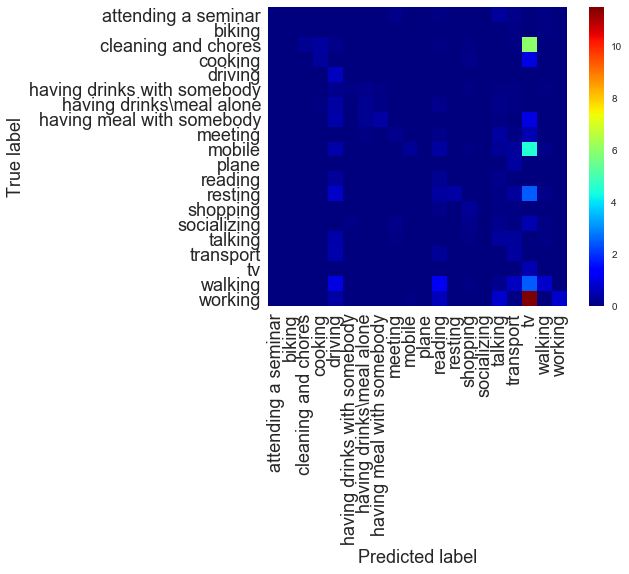

In [96]:
plot_confusion_matrix(y_data,y_pred_rf,normalize=True)

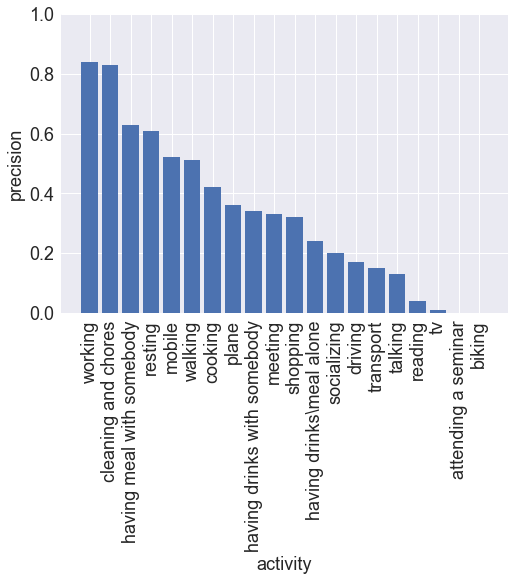

In [62]:
a = classification_report(y_data,y_pred_rf)
a= a.split('\n')
precision=[]
x_act = sorted(y_data.unique())
for i,v in enumerate(a):
    if i>=2:      
        if (v != ''):
            if 'avg' not in v:   
                value= float(v[33:39])
                precision.append(value) 

activity_score={}
for i,v in enumerate(x_act):
    activity_score[v]=precision[i]
    
list= sorted(activity_score.items(), key=lambda x:x[1],reverse=True)
#print list
x_val = [x[0] for x in list]
y_val = [x[1] for x in list]

x_num= np.arange(len(x_val))
plt.xticks(x_num,x_val,rotation= 90,fontsize= 18)
plt.bar(x_num,y_val)
plt.xlabel('activity',fontsize = 18)
plt.ylim([0.0,1.0])
plt.ylabel('precision',fontsize=18)
plt.yticks(fontsize= 18)
plt.show()

In [63]:
print "classification accuracy:", accuracy_score(y_data, y_pred_rf)

classification accuracy: 0.49826004429


In [64]:
#TEST MODEL FOR EVERY USER INDIVIDUALLY

In [65]:
df_user1=df2[df2['user']=='u1']
df_user2=df2[df2['user']=='u2']
df_user3=df2[df2['user']=='u3']
y1 = df_user1[1:]['activity']
X1 = df_user1[1:][tags3]
y2 = df_user2[1:]['activity']
X2 = df_user2[1:][tags3]
y3 = df_user3[1:]['activity']
X3 = df_user3[1:][tags3]

In [66]:
PRC = 0.3
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=PRC)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=PRC)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=PRC)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train1,y_train1)   
y_pred_rf1 = rf.predict(X_test1)
print "classification accuracy:", accuracy_score(y_test1, y_pred_rf1)
rf.fit(X_train2,y_train2)   
y_pred_rf2 = rf.predict(X_test2)
print "classification accuracy:", accuracy_score(y_test2, y_pred_rf2)
rf.fit(X_train1,y_train1)   
y_pred_rf3 = rf.predict(X_test3)
print "classification accuracy:", accuracy_score(y_test3, y_pred_rf3)

classification accuracy: 0.760770768951
classification accuracy: 0.800927878532
classification accuracy: 0.358384332925
